# Magnetization

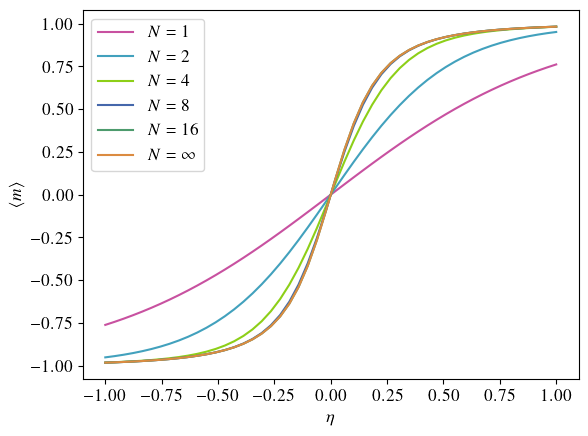

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("../custom.matplotlibrc")

def lambda_plus(zeta, eta):
    c = np.cosh(eta)
    s = np.sinh(eta)
    
    return np.exp(zeta) * (c + np.sqrt(s**2 + np.exp(-4 * zeta)))

def lambda_minus(zeta, eta):
    c = np.cosh(eta)
    s = np.sinh(eta)
    
    return np.exp(zeta) * (c - np.sqrt(s**2 + np.exp(-4 * zeta)))

def magnetization(zeta, eta, N):
    s = np.sinh(eta)
    c = np.cosh(eta)
    
    lp = lambda_plus(zeta, eta)
    lm = lambda_minus(zeta, eta)
    
    fac = c / np.sqrt(s**2 + np.exp(-4 * zeta))
    
    return N * np.exp(zeta) * s  / (np.power(lp, N) + np.power(lm, N)) * (np.power(lp, N-1) * (1 + fac) + np.power(lm, N-1) * (1 - fac))

def high_n_limit(zeta, eta):
    e = np.exp(-4*zeta)
    s = np.sinh(eta)
    
    return s / np.sqrt(s**2 + e)



r = 1
x = np.linspace(-r, r, 50)

zeta = 0.75
for n in [1, 2, 4, 8, 16]:
    plt.plot(x, magnetization(zeta, x, n) / n, label=f"$N = \\num{{{n}}}$")
plt.plot(x, high_n_limit(zeta, x), label=r"$N = \infty$")
plt.legend()
plt.xlabel(r"$\eta$")
plt.ylabel(r"$\expval{m}$")
plt.savefig("magnetization.pdf")
# plt.ylim(-12, 12)

# Defining the System Class

In [2]:
class SpinSystem:
    """

    A class that calculates the Action of a given spin configuration

    :param spin_config: Array of +/- 1 values
    :param float zeta: ζ = J / T dimensionless parameter for coupling spin strength
    :param float eta: η = h / T dimensionless parameter for magnetic field strengh
    :param int n: Number of spins

    """

    def __init__(self, zeta: float, eta: float, n: int):
        self.zeta = zeta
        self.eta = eta
        self.n = n

    def action(self, spin_config: np.ndarray):
        if spin_config.__len__() != self.n:
            raise ValueError(f"spin_config has to have the dimension {self.n}")

        h = (spin_config[:-1] * spin_config[1:]).sum()

        return self.zeta * h - self.eta * spin_config.sum()

    def delta_action(self, spin_config: np.ndarray, spin_flip: int | np.ndarray):
        """

        Calculates the difference in the action of a given configuration, if a spin_flip at one position occurs.

        :param int | np.ndarray spin_flip: index of spin flip position.

        """

        # error with boundaries
        if spin_flip == 0:
            return 2 * spin_config[0] * (self.eta - self.zeta * spin_config[1])
        elif spin_flip == self.n - 1:
            return 2 * spin_config[spin_flip] * (self.eta - self.zeta * spin_config[spin_flip - 1])

        spins = spin_config[spin_flip - 1 : spin_flip + 2]
        return 2 * spins[1] * (self.eta - self.zeta * (spins[0] + spins[2]))
    
    def magnetization(self, spin_config) -> np.ndarray:
        return spin_config.sum(axis=1) / self.n

    def generate_spin_config(self):
        return np.random.choice([-1, 1], size=self.n)

# $S$ and $\Delta S$ scaling

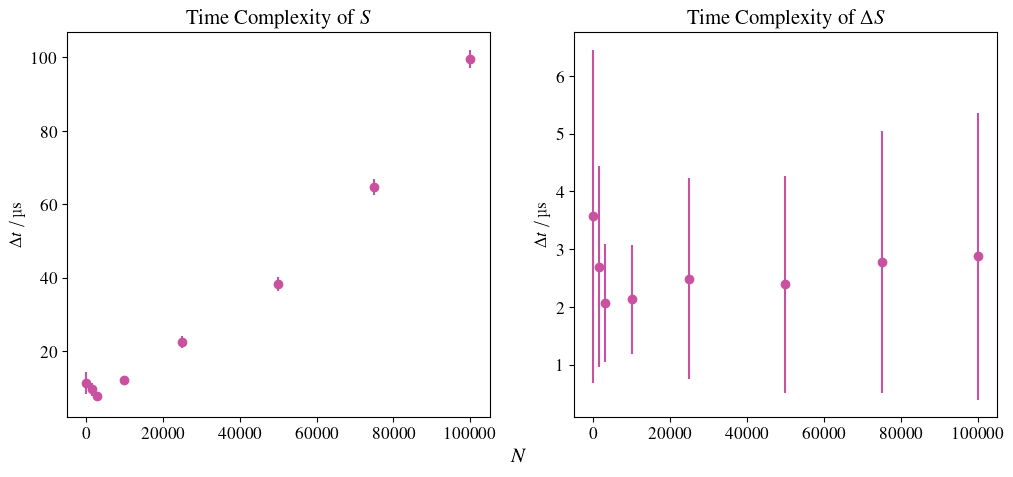

In [3]:
from time import time_ns

action_time_averages = []
delta_action_time_averages = []
action_time_std = []
delta_action_time_std = []

barstyle = {
    "lines.linestyle": "",
    "lines.marker": "o"
}

spin_numbers = [50, 1_500, 3_000, 10_000, 25_000, 50_000, 75_000, 100_000]

for n in spin_numbers:
    system = SpinSystem(zeta=.75, eta=0.5, n=n)

    action_times = []
    delta_action_times = []
    
    for _ in range(1000):
        config = system.generate_spin_config()

        start = time_ns()
        system.action(config) 
        action_times.append((time_ns() - start) / 1000)

        start = time_ns()
        system.delta_action(config, 1)
        delta_action_times.append((time_ns() - start) / 1000)
    
    action_time_averages.append(np.mean(action_times))
    action_time_std.append(np.std(delta_action_times))
    delta_action_time_averages.append(np.mean(delta_action_times))
    delta_action_time_std.append(np.std(delta_action_times))
        

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

with plt.rc_context(barstyle):
    ax[0].errorbar(spin_numbers, action_time_averages, yerr=action_time_std)
    ax[1].errorbar(spin_numbers, delta_action_time_averages, yerr=delta_action_time_std)
    
    ax[0].set_ylabel(r"$\Delta t \,/\, \unit{\micro\second}$")
    ax[0].set_title(r"Time Complexity of $S$")
    ax[1].set_ylabel(r"$\Delta t \,/\, \unit{\micro\second}$")
    ax[1].set_title(r"Time Complexity of $\Delta S$")
    fig.supxlabel(r"$N$")
    fig.savefig("action_spin_number_scaling.pdf")


# MCMC

In [9]:
from copy import deepcopy


class IsingModelMCMC:
    def __init__(self, spin_system: SpinSystem):
        self.spin_system = spin_system

    def calculate_next(self, spin_config) -> any:
        spin_flip = np.random.choice(range(self.spin_system.n))

        acceptance = min(
            1, np.exp(-self.spin_system.delta_action(spin_config, spin_flip))
        )
        u = np.random.uniform(0, 1)
        if acceptance >= u:
            new_config = deepcopy(spin_config)
            new_config[spin_flip] *= -1
            return new_config
        return spin_config

    def __call__(self, start_config: np.ndarray, array_length: int) -> np.ndarray:
        """Generate a Markov Chain"""

        configs = [start_config]
        for _ in range(1, array_length):
            new = self.calculate_next(configs[-1])
            configs.append(new)

        return np.array(configs)


from matplotlib.colors import LinearSegmentedColormap, to_hex

N = 20
CONFIGS = 10_000
NUMBER_OF_M_PER_ETA = 2

# cmap = LinearSegmentedColormap.from_list("colormap", list(zip([0, 0.5, 1], ["blue", "grey", "red"])))

# def get_color(x):
#     return to_hex(cmap(1/2 * (x + 1)))

# start_config = np.array([1, -1] * int(N / 2))
start_config = np.array([1] * N)
m = np.array([])
m_std = np.array([])
eta_values = np.linspace(-1, 1, 20)

# fig, ax = plt.subplots()
for eta in eta_values:
    system = SpinSystem(zeta=0.75, eta=eta, n=N)
    mcmc = IsingModelMCMC(system)

    values = np.array([])

    for _ in range(NUMBER_OF_M_PER_ETA):
        configs = mcmc(start_config, CONFIGS)
        magnetization = system.magnetization(configs)
        values = np.append(values, magnetization.mean())

    m = np.append(m, values.mean())
    m_std = np.append(m_std, values.std())


with plt.rc_context(barstyle):
    plt.errorbar(eta_values, m, yerr=m_std)
    plt.xlabel(r"Magnetic Field Strength $\eta$")
    plt.ylabel(r"Magnetization $\langle m \rangle$")
    # plt.savefig(r"mean_magnetization_mcmc.pdf")

Error in callback <function _draw_all_if_interactive at 0x7f6e84965800> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: latex was not able to process the following string:
b'Magnetization \\\\expval{m}'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpktiffu9_ fb63398226c0093a1bc10e4c87b8f4ec.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023/Fedora 40) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./fb63398226c0093a1bc10e4c87b8f4ec.tex
LaTeX2e <2022-11-01> patch level 1
L3 programming layer <2023-02-22>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2022/07/02 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/newtx/newtx.sty
`newtx'v1.71, 2022/02/11 Integrated loading of newtxmath and a text font  for a
ll latex engines (msharpe)
(/usr/share/texlive/texmf-dist/tex/latex/base/fontenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/fontaxes/fontaxes.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/ifthen.sty)
(/usr/share/texlive/texmf-dist/tex/latex/etoolbox/etoolbox.sty)
(/usr/share/texlive/texmf-dist/tex/latex/carlisle/scalefnt.sty)
(/usr/share/texlive/texmf-dist/tex/latex/xkeyval/xkeyval.sty
(/usr/share/texlive/texmf-dist/tex/generic/xkeyval/xkeyval.tex
(/usr/share/texlive/texmf-dist/tex/generic/xkeyval/xkvutils.tex)))
type1 math
type1 text
(/usr/share/texlive/texmf-dist/tex/latex/newtx/newtxmath.sty
`newtxmath' v1.71, 2022/01/16 Math macros based originally on txfonts (msharpe)
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsmath.sty
For additional information on amsmath, use the `?' option.
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amstext.sty
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsgen.sty))
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsbsy.sty)
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsopn.sty))
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifxetex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifluatex.sty)
(/usr/share/texlive/texmf-dist/tex/latex/oberdiek/centernot.sty)
(/usr/share/texlive/texmf-dist/tex/generic/kastrup/binhex.tex)
amsthm NOT loaded
) (/usr/share/texlive/texmf-dist/tex/latex/newtx/newtxtext.sty
`newtxtext' v1.71, 2022/02/28 Text macros taking advantage of TeXGyre Termes an
d its extensions (msharpe)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/generic/xstring/xstring.sty
(/usr/share/texlive/texmf-dist/tex/generic/xstring/xstring.tex))
(/usr/share/texlive/texmf-dist/tex/generic/kastrup/binhex.tex)
ntx@otftextfalse
)) (/usr/share/texlive/texmf-dist/tex/latex/mathtools/mathtools.sty
(/usr/share/texlive/texmf-dist/tex/latex/tools/calc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/mathtools/mhsetup.sty))
(/usr/share/texlive/texmf-dist/tex/latex/siunitx/siunitx.sty
(/usr/share/texlive/texmf-dist/tex/latex/translations/translations.sty
(/usr/share/texlive/texmf-dist/tex/generic/pdftexcmds/pdftexcmds.sty
(/usr/share/texlive/texmf-dist/tex/generic/infwarerr/infwarerr.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ltxcmds/ltxcmds.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/tools/array.sty))
(/usr/share/texlive/texmf-dist/tex/latex/physics/physics.sty
(/usr/share/texlive/texmf-dist/tex/latex/l3packages/xparse/xparse.sty
(/usr/share/texlive/texmf-dist/tex/latex/l3kernel/expl3.sty
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def))))
(/usr/share/texlive/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/share/texlive/texmf-dist/tex/latex/newtx/ot1ntxtlf.fd)
No file fb63398226c0093a1bc10e4c87b8f4ec.aux.
(/usr/share/texlive/texmf-dist/tex/latex/newtx/omlntxmi.fd)
(/usr/share/texlive/texmf-dist/tex/latex/newtx/untxexa.fd)
(/usr/share/texlive/texmf-dist/tex/latex/newtx/lmsntxsy.fd)
(/usr/share/texlive/texmf-dist/tex/latex/newtx/lmxntxexx.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
(/usr/share/texlive/texmf-dist/tex/latex/graphics/graphicx.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/graphics.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/trig.sty)
(/usr/share/texlive/texmf-dist/tex/latex/graphics-cfg/graphics.cfg)
(/usr/share/texlive/texmf-dist/tex/latex/graphics-def/dvips.def)))
(/usr/share/texlive/texmf-dist/tex/latex/graphics/color.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics-cfg/color.cfg)
(/usr/share/texlive/texmf-dist/tex/latex/graphics/dvipsnam.def)
(/usr/share/texlive/texmf-dist/tex/latex/graphics/mathcolor.ltx))

Package siunitx Warning: Detected the "physics" package:
(siunitx)                omitting definition of \qty.
(siunitx)                
(siunitx)                If you want to use \qty with the siunitx definition,
(siunitx)                add 
(siunitx)                
(siunitx)                    \AtBeginDocument{\RenewCommandCopy\qty\SI}
(siunitx)                
(siunitx)                to your preamble.


(/usr/share/texlive/texmf-dist/tex/latex/translations/translations-basic-dictio
nary-english.trsl)
! Missing $ inserted.
<inserted text> 
                $
l.29 {\rmfamily Magnetization \expval{m}}
                                         %
No pages of output.
Transcript written on tmpktiffu9_/fb63398226c0093a1bc10e4c87b8f4ec.log.




RuntimeError: latex was not able to process the following string:
b'Magnetization \\\\expval{m}'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmp0kcrlp6j fb63398226c0093a1bc10e4c87b8f4ec.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023/Fedora 40) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./fb63398226c0093a1bc10e4c87b8f4ec.tex
LaTeX2e <2022-11-01> patch level 1
L3 programming layer <2023-02-22>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2022/07/02 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/newtx/newtx.sty
`newtx'v1.71, 2022/02/11 Integrated loading of newtxmath and a text font  for a
ll latex engines (msharpe)
(/usr/share/texlive/texmf-dist/tex/latex/base/fontenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/fontaxes/fontaxes.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/ifthen.sty)
(/usr/share/texlive/texmf-dist/tex/latex/etoolbox/etoolbox.sty)
(/usr/share/texlive/texmf-dist/tex/latex/carlisle/scalefnt.sty)
(/usr/share/texlive/texmf-dist/tex/latex/xkeyval/xkeyval.sty
(/usr/share/texlive/texmf-dist/tex/generic/xkeyval/xkeyval.tex
(/usr/share/texlive/texmf-dist/tex/generic/xkeyval/xkvutils.tex)))
type1 math
type1 text
(/usr/share/texlive/texmf-dist/tex/latex/newtx/newtxmath.sty
`newtxmath' v1.71, 2022/01/16 Math macros based originally on txfonts (msharpe)
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsmath.sty
For additional information on amsmath, use the `?' option.
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amstext.sty
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsgen.sty))
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsbsy.sty)
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsopn.sty))
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifxetex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifluatex.sty)
(/usr/share/texlive/texmf-dist/tex/latex/oberdiek/centernot.sty)
(/usr/share/texlive/texmf-dist/tex/generic/kastrup/binhex.tex)
amsthm NOT loaded
) (/usr/share/texlive/texmf-dist/tex/latex/newtx/newtxtext.sty
`newtxtext' v1.71, 2022/02/28 Text macros taking advantage of TeXGyre Termes an
d its extensions (msharpe)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/generic/xstring/xstring.sty
(/usr/share/texlive/texmf-dist/tex/generic/xstring/xstring.tex))
(/usr/share/texlive/texmf-dist/tex/generic/kastrup/binhex.tex)
ntx@otftextfalse
)) (/usr/share/texlive/texmf-dist/tex/latex/mathtools/mathtools.sty
(/usr/share/texlive/texmf-dist/tex/latex/tools/calc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/mathtools/mhsetup.sty))
(/usr/share/texlive/texmf-dist/tex/latex/siunitx/siunitx.sty
(/usr/share/texlive/texmf-dist/tex/latex/translations/translations.sty
(/usr/share/texlive/texmf-dist/tex/generic/pdftexcmds/pdftexcmds.sty
(/usr/share/texlive/texmf-dist/tex/generic/infwarerr/infwarerr.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ltxcmds/ltxcmds.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/tools/array.sty))
(/usr/share/texlive/texmf-dist/tex/latex/physics/physics.sty
(/usr/share/texlive/texmf-dist/tex/latex/l3packages/xparse/xparse.sty
(/usr/share/texlive/texmf-dist/tex/latex/l3kernel/expl3.sty
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def))))
(/usr/share/texlive/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/share/texlive/texmf-dist/tex/latex/newtx/ot1ntxtlf.fd)
No file fb63398226c0093a1bc10e4c87b8f4ec.aux.
(/usr/share/texlive/texmf-dist/tex/latex/newtx/omlntxmi.fd)
(/usr/share/texlive/texmf-dist/tex/latex/newtx/untxexa.fd)
(/usr/share/texlive/texmf-dist/tex/latex/newtx/lmsntxsy.fd)
(/usr/share/texlive/texmf-dist/tex/latex/newtx/lmxntxexx.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
(/usr/share/texlive/texmf-dist/tex/latex/graphics/graphicx.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/graphics.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/trig.sty)
(/usr/share/texlive/texmf-dist/tex/latex/graphics-cfg/graphics.cfg)
(/usr/share/texlive/texmf-dist/tex/latex/graphics-def/dvips.def)))
(/usr/share/texlive/texmf-dist/tex/latex/graphics/color.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics-cfg/color.cfg)
(/usr/share/texlive/texmf-dist/tex/latex/graphics/dvipsnam.def)
(/usr/share/texlive/texmf-dist/tex/latex/graphics/mathcolor.ltx))

Package siunitx Warning: Detected the "physics" package:
(siunitx)                omitting definition of \qty.
(siunitx)                
(siunitx)                If you want to use \qty with the siunitx definition,
(siunitx)                add 
(siunitx)                
(siunitx)                    \AtBeginDocument{\RenewCommandCopy\qty\SI}
(siunitx)                
(siunitx)                to your preamble.


(/usr/share/texlive/texmf-dist/tex/latex/translations/translations-basic-dictio
nary-english.trsl)
! Missing $ inserted.
<inserted text> 
                $
l.29 {\rmfamily Magnetization \expval{m}}
                                         %
No pages of output.
Transcript written on tmp0kcrlp6j/fb63398226c0093a1bc10e4c87b8f4ec.log.




<Figure size 640x480 with 1 Axes>